# ICR - Identifying Age-Related Conditions
Вихляев Е.С., ММТ-21

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree  import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import KFold

### Задача

Определить, есть ли у человека какое-либо их трех заболеваний. Метка класса 1 соответствует тому, что есть хотя бы одно заболевание, а метка класса 0 соответствует тому, что заболеваний нет.

### Описание датасета

- train.csv - тренировочный набор.
    - Id - уникальный идентификатор для каждого наблюдения.
    - AB-GL - 56 обезличенных характеристик здоровья. Каждая из них числовая, за исключением EJ, которая является категориальной.
    - Class - целевая переменная. 1 указывает на то, что у испытуемого было диагностировано одно из трех заболеваний, 0 указывает на то, что у него заболеваний нет.
- test.csv - тестовый набор. Нужно предсказать вероятность того, что испытуемый из этого набора принадлежит к одному из двух классов.
- greeks.csv - дополнительные метаданные, доступные только для тренировочного набора.
    - Alpha - определяет тип возрастного заболевания, если таковое имеется.
        - A - нет возрастных изменений. Соответствует классу 0.
        - B, D, G - три возрастных изменения. Соответствует классу 1.
    - Beta, Gamma, Delta - три эксперементальных характеристики.
    - Epsilon - дата, когда были собраны данные по данному субъекту. Обратите внимание, что все данные в тестовом наборе были собраны после того, как был собран тренировочный набор данных.
- sample_submission.csv - образец файла для отправки в нужном формате.

[Источник](https://www.kaggle.com/competitions/icr-identify-age-related-conditions/overview).

### Загрузка датасета

In [2]:
df = pd.read_csv('train.csv')
print('Полный размер тренировочного датасета:', df.shape)

Полный размер тренировочного датасета: (617, 58)


Имеем 58 столбцов и 617 записей.

In [3]:
df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


Видим, что в датасете явно выделена целевая переменная class, по которой и будем проводить классификацию. Здесь метка класса 1 указывает, есть ли у человека одно или более из представленных трех заболеваний. Метка класса 0 указывает, что у человека нет ни одного из трех заболеваний.

### Быстрый базовый EDA

In [4]:
df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

Посмотрим на круговую диаграмму распределения целевой переменной.

<Axes: ylabel='count'>

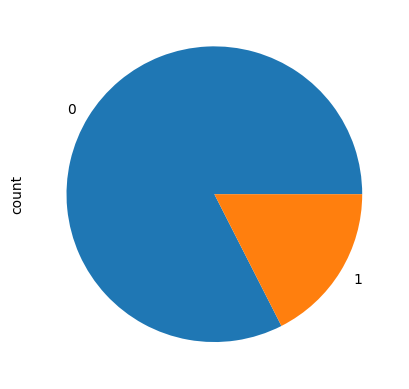

In [6]:
plot_df = df.Class.value_counts()
plot_df.plot(kind='pie')

Из диаграммы видим, что наш датасет имеет сильный дисбаланс классов в пользу метки класса 1.

Далее рассмотрим распределение числовых данных.

Для начала выделим все численные столбцы наших признаков, то есть исключим из рассмотрения очевидные числовые столбцы как Id, EJ и столбец целевой переменной Class.

In [7]:
num_feature_columns = [i for i in df.columns if i not in ['Id', 'EJ', 'Class']]
#num_feature_columns

Изобразим первые 6 числовых столбца и их значения через bag charts.

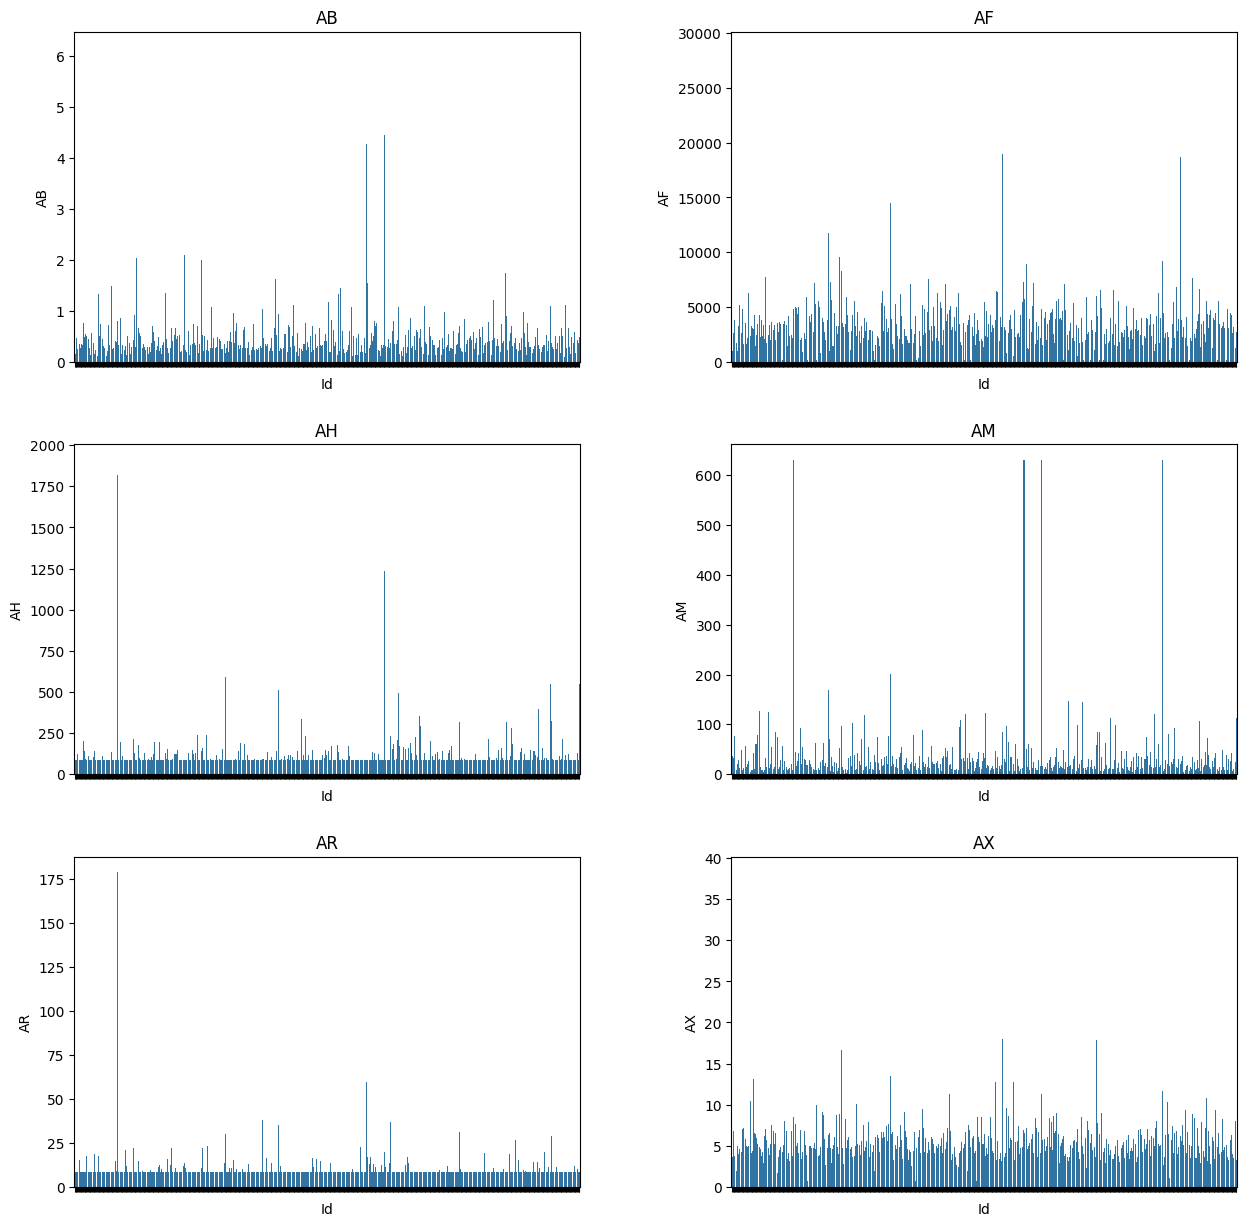

In [8]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(num_feature_columns[:6]):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=df['Id'], y = df[column_name])
    bp.set(xticklabels=[])
    axis[row, col].set_title(column_name)

plt.show()

Так же выделим столбцы признаков отдельно.

In [9]:
feature_columns = [i for i in df.columns if i not in ['Id']]
#feature_columns

Рассмотрим пропущенные значения.

In [11]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 548 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      548 non-null    object 
 1   AB      548 non-null    float64
 2   AF      548 non-null    float64
 3   AH      548 non-null    float64
 4   AM      548 non-null    float64
 5   AR      548 non-null    float64
 6   AX      548 non-null    float64
 7   AY      548 non-null    float64
 8   AZ      548 non-null    float64
 9   BC      548 non-null    float64
 10  BD      548 non-null    float64
 11  BN      548 non-null    float64
 12  BP      548 non-null    float64
 13  BQ      548 non-null    float64
 14  BR      548 non-null    float64
 15  BZ      548 non-null    float64
 16  CB      548 non-null    float64
 17  CC      548 non-null    float64
 18  CD      548 non-null    float64
 19  CF      548 non-null    float64
 20  CH      548 non-null    float64
 21  CL      548 non-null    float64
 22  CR     

Как можем заметить, записей стало 548 вместо 617. НАДО ПРОВЕСТИ ИССЛЕДОВАНИЕ ПРОПУСКОВ И РЕШИТЬ: УДАЛИТЬ ИХ ИЛИ ЗАМЕНИТЬ

Рекомендации

Анализируйте природу пропусков: Определите, случайны ли пропуски или имеют системный характер. Если пропуски случайны, их можно заменить; если нет, возможно, лучше удалить.

Оцените объем данных: Если у вас достаточно данных и только несколько пропусков, удаление может быть приемлемым. Если же данные ограничены, рассмотрите возможность замены.

Используйте комбинацию подходов: В некоторых случаях полезно комбинировать методы — например, удалить строки с критическими пропусками и заменить менее важные значения.

Приступим к разделению датасета на тренировочную и тестовую выборки.

### KFold Validation